In [1]:


%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wget

import seaborn
import numpy as np
import pandas as pd
import pylab
import sklearn.preprocessing

import scgenome

import dbclients.tantalus
from dbclients.basicclient import NotFoundError
import datamanagement.transfer_files

import envsetup

sample_ids = [
    'SA039',
    'SA1101',
    'SA906',
]

local_storage_directory = '/home/ubuntu/tantalus_data/'

results_storage_name = 'singlecellblob_results'

tantalus_api = dbclients.tantalus.TantalusApi()

client = tantalus_api.get_storage_client(results_storage_name)


ImportError: No module named scgenome

In [ ]:

library_ids = [
    'A96225B',
    'A96162A',
    'A96155C',
    'A96240A',
    'A96225C',
    'A96193B',
    'A96183B',
    'A96240B',
    'A96181C',
    'A96233B',
    'A96190A',
#     'A95634B',
#     'A95668B',
#     'A95663B',
    'A96180B',
    'A96210C',
    'A96216A',
    'A96175C',
#     'A96195A',
    'A96183C',
    'A96163B',
    'A96186A',
    'A96189B',
    'A96146A',
#     'A96215A',
    'A96170B',
    'A96211C',
    'A96172B',
    'A96155B',
    'A96220B',
    'A96228B',
    'A96149B',
    'A96193A',
    'A90554C',
    'A90600C',
    'A73046B',
    'A73056B',
    'A95660A',
    'A96199B',
    'A96226B',
    'A73044B',
    'A73047D',
]


In [ ]:

hmmcopy_results = {}
hmmcopy_tickets = []

for library_id in library_ids:
    print library_id
    analyses = list(tantalus_api.list(
        'analysis',
        analysis_type__name='hmmcopy',
        input_datasets__library__library_id=library_id,
    ))
    aln_analyses = []
    for analysis in analyses:
        aligners = set()
        for dataset_id in analysis['input_datasets']:
            dataset = tantalus_api.get('sequencedataset', id=dataset_id)
            aligners.add(dataset['aligner'])
        if len(aligners) != 1:
            raise Exception('found {} aligners for analysis {}'.format(
                len(aligners), analysis['id']))
        aligner = aligners.pop()
        if aligner == 'BWA_ALN_0_5_7':
            aln_analyses.append(analysis)
    if len(aln_analyses) != 1:
        raise Exception('found {} hmmcopy analyses for {}: {}'.format(
            len(aln_analyses), library_id, [a['id'] for a in aln_analyses]))
    analysis = aln_analyses[0]
    results = tantalus_api.get(
        'resultsdataset',
        analysis=analysis['id'],
    )
    hmmcopy_results[library_id] = results
    hmmcopy_tickets.append(analysis['jira_ticket'])


In [ ]:

cell_cycle_data = []
for library_id in library_ids:
    print library_id
    classifier = tantalus_api.get(
        'analysis',
        analysis_type='cell_state_classifier',
        version='v0.0.1',
        input_results__id=hmmcopy_results[library_id]['id'],
    )
    features = tantalus_api.get(
        'resultsdataset',
        analysis=classifier['id'],
    )
    file_instances = tantalus_api.get_dataset_file_instances(
        features['id'], 'resultsdataset', results_storage_name)
    for file_instance in file_instances:
        f = client.open_file(file_instance['file_resource']['filename'])
        data = pd.read_csv(f)
        data['library_id'] = library_id
        cell_cycle_data.append(data)
cell_cycle_data = pd.concat(cell_cycle_data, ignore_index=True)
cell_cycle_data.head()


In [ ]:

image_feature_data = []
for library_id in library_ids:
    try:
        features = tantalus_api.get(
            'results',
            results_type='CELLENONE_FEATURES',
            results_version='v0.0.1',
            libraries__library_id=library_id,
        )
    except NotFoundError:
        continue
    file_instances = tantalus_api.get_dataset_file_instances(
        features['id'], 'resultsdataset', results_storage_name)
    for file_instance in file_instances:
        f = client.open_file(file_instance['file_resource']['filename'])
        data = pd.read_csv(f, index_col=0)
        data['library_id'] = library_id
        image_feature_data.append(data)
image_feature_data = pd.concat(image_feature_data, ignore_index=True)


In [ ]:

image_feature_data.groupby(['library_id', 'spotter']).size().rename('count').reset_index()


In [ ]:

plot_data = image_feature_data[image_feature_data['spotter'] == 'rachael']

seaborn.factorplot(
    x='Diameter',
    y='library_id',
    data=plot_data,
    kind='box',
)


In [ ]:

import scgenome.dataimport

results = scgenome.dataimport.import_cn_data(
    hmmcopy_tickets,
    local_storage_directory,
    ploidy_solution='2',
    subsample=0.25,
)

cn_data = results['hmmcopy_reads']
metrics_data = results['hmmcopy_metrics']


In [ ]:

cn_data['chr'] = cn_data['chr'].astype('category')
cn_data['cell_id'] = cn_data['cell_id'].astype('category')
cn_data['sample_id'] = cn_data['sample_id'].astype('category')
cn_data['library_id'] = cn_data['library_id'].astype('category')


In [ ]:

metrics_data = metrics_data.merge(cell_cycle_data)

metrics_data['total_mapped_reads'] = metrics_data.get('total_mapped_reads')
metrics_data['total_mapped_reads_hmmcopy'] = metrics_data.get('total_mapped_reads_hmmcopy')
metrics_data['total_mapped_reads'] = np.maximum(
    metrics_data['total_mapped_reads'].fillna(0),
    metrics_data['total_mapped_reads_hmmcopy'].fillna(0))

for library_id, library_metrics_data in metrics_data.groupby('library_id'):
    plt.figure()
    plt.title(library_id)
    library_metrics_data['total_mapped_reads'].hist(bins=50)

test_data = metrics_data.copy()
test_data['is_in_sample_list'] = test_data['sample_id'].isin(sample_ids)
test_data[['library_id', 'sample_id', 'is_in_sample_list']].drop_duplicates()


In [ ]:

metrics_data['brief_cell_id'] = metrics_data['cell_id'].apply(lambda a: a.split('-', 1)[1])


In [ ]:

metrics_data['total_mapped_reads'].hist()

print 'original', len(metrics_data['cell_id'].unique())
metrics_data = metrics_data[metrics_data['total_mapped_reads'] > 500000]
print 'readcount', len(metrics_data['cell_id'].unique())
# metrics_data = metrics_data[metrics_data['quality'] > 0.5]
print 'quality', len(metrics_data['cell_id'].unique())

cn_data = cn_data.merge(metrics_data[['cell_id']].drop_duplicates())


In [ ]:

import scgenome.cncluster

cn = cn_data.set_index(['chr', 'start', 'cell_id'])['copy'].unstack(level=2).fillna(0)

# Remove s phase cells
non_s_cells = metrics_data[~metrics_data['is_s_phase']]['cell_id']
cn = cn.reindex(columns=non_s_cells)

cluster_df = scgenome.cncluster.umap_hdbscan_cluster(cn)

clone_cn = (
    cn_data.merge(cluster_df).groupby(['chr', 'start', 'end', 'cluster_id'])['copy']
    .median().rename('clone_cn').reset_index())

cluster_df.groupby('cluster_id').size().rename('size').reset_index()


In [ ]:

scgenome.cncluster.plot_umap_clusters(plt.gca(), cluster_df)


In [ ]:

if 'cluster_id' in cn_data:
    cn_data = cn_data.drop('cluster_id', axis=1)
cn_data = cn_data.merge(cluster_df[['cell_id', 'cluster_id']], on='cell_id')
cn_data.head()


In [ ]:


cn_data2 = cn_data.copy()
cn_data2['clone_var'] = np.square(cn_data2['integer_copy_number'] - cn_data2['clone_cn'])
clone_std = cn_data2.groupby('cell_id')['clone_var'].sum().pow(1./2).rename('clone_std').reset_index()
clone_rms = cn_data2.groupby('cell_id')['clone_var'].mean().pow(1./2).rename('clone_rms').reset_index()

cluster_df = cluster_df.merge(clone_std)
cluster_df = cluster_df.merge(clone_rms)

cluster_df['clone_std'] = cluster_df['clone_std']#.clip_upper(75.)

fig = plt.figure(figsize=(8, 8))
plt.scatter(
    cluster_df['umap1'].values,
    cluster_df['umap2'].values,
    c=cluster_df['clone_std'].values,
    cmap=plt.get_cmap("Reds"),
    s=2)

fig = plt.figure()
cluster_df['clone_std'].hist(bins=30)

print len(cluster_df['cell_id'].unique())
cluster_df = cluster_df[cluster_df['clone_std'] < 60.]
print len(cluster_df['cell_id'].unique())
clone_counts = cluster_df.groupby('cluster_id')['cell_id'].count()
print clone_counts
clone_counts_filter = clone_counts[clone_counts >= 50].reset_index()
cluster_df = cluster_df.merge(clone_counts_filter[['cluster_id']])
print len(cluster_df['cell_id'].unique())
print cluster_df.groupby('cluster_id')['cell_id'].count().describe()

cluster_df['is_filtered'] = cluster_df['clone_std'] < 60.
seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_std', kind='strip', jitter=True)
seaborn.factorplot(data=cluster_df, x='is_filtered', y='clone_rms', kind='strip', jitter=True)

cn_data_filtered = cn_data[cn_data['cell_id'].isin(cluster_df['cell_id'].unique())]

cluster_df.groupby('is_filtered')['clone_std'].describe()
cluster_df.groupby('is_filtered')['clone_rms'].describe()

# cn_data_filtered = cn_data.drop('cluster_id', axis=1).merge(cluster_df)
# cn_data_filtered = cn_data_filtered.query('cluster_id >= 0')

# cn_data_filtered.head()


In [ ]:

import scgenome.cnplot

plot_data = cn_data_filtered.copy()
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', raw=True)


In [ ]:

plot_data = cn_data_filtered.copy()
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state')


In [ ]:

breakpoint_data = (
    metrics_data
    .merge(cluster_df)
    .groupby('cluster_id')['breakpoints']
    .mean().reset_index()
    .sort_values('breakpoints'))

filtered_clusters = breakpoint_data[
    (breakpoint_data['cluster_id'] >= 0) &
    (breakpoint_data['breakpoints'] < 50.)
]

breakpoint_data['breakpoints'].hist(bins=40)

breakpoint_data


In [ ]:

cn_data_filtered2 = cn_data_filtered.merge(filtered_clusters)

import scgenome.cnplot

fig = plt.figure(figsize=(15, 16))
scgenome.cnplot.plot_cluster_cn_matrix(fig, cn_data_filtered2, 'state')


In [ ]:

cell_cn_matrix = cn_data.set_index(['chr', 'start', 'cell_id'])['copy'].unstack(level=2).fillna(0)
cell_cn_matrix.head()


In [ ]:

clone_cn = (
    cn_data_filtered2.dropna().groupby(['chr', 'start', 'cluster_id'])['copy']
    .median().reset_index())

clone_cn_matrix = clone_cn.set_index(['chr', 'start', 'cluster_id'])['copy'].unstack(level=2).fillna(0)
clone_cn_matrix.head()


In [ ]:

cell_clone_corr = {}
for cluster_id in clone_cn_matrix.columns:
    print cluster_id
    cell_clone_corr[cluster_id] = cell_cn_matrix.corrwith(clone_cn_matrix[cluster_id])


In [ ]:

recluster_df = pd.DataFrame(cell_clone_corr).idxmax(axis=1).dropna().astype(int)
recluster_df.name = 'recluster_id'
recluster_df = recluster_df.reset_index()
recluster_df.head()

metrics_data.merge(recluster_df).groupby('recluster_id')['is_s_phase'].mean()


In [47]:

plot_cluster_id = '34'

non_s_cells = metrics_data[~metrics_data['is_s_phase']][['cell_id']]
non_s_cell_ids = metrics_data.merge(recluster_df).merge(non_s_cells).query('recluster_id == ' + plot_cluster_id)['cell_id'].unique()

s_cells = metrics_data[metrics_data['is_s_phase']][['cell_id']]
s_cell_ids = metrics_data.merge(recluster_df).merge(s_cells).query('recluster_id == ' + plot_cluster_id)['cell_id'].unique()

print len(non_s_cell_ids)
print len(s_cell_ids)

cell_id = non_s_cell_ids[5]
cell_id = s_cell_ids[10]

print cell_id

metrics_data.query('cell_id == "{}"'.format(cell_id)).iloc[0]


0
0


IndexError: index 5 is out of bounds for axis 0 with size 0

In [93]:

clone_cn = (
    cn_data.merge(cluster_df).groupby(['chr', 'start', 'end', 'cluster_id'])['copy']
    .median().rename('clone_cn').reset_index())

clone_cn.head()


,chr,start,end,cluster_id,clone_cn
0,1,1,500000,-1,NaN
1,1,1,500000,0,NaN
2,1,1,500000,1,NaN
3,1,1,500000,2,NaN
4,1,1,500000,3,NaN


In [98]:

plot_clone_cn = (
    cn_data
    .merge(cluster_df)
    .groupby(['chr', 'start', 'end', 'cluster_id'])
    .agg({'copy': 'mean', 'integer_copy_number': 'median'})
    .reset_index())
plot_clone_cn.head()


,chr,start,end,cluster_id,copy,integer_copy_number
0,1,1,500000,-1,NaN,2.0
1,1,1,500000,0,NaN,2.0
2,1,1,500000,1,NaN,2.0
3,1,1,500000,2,NaN,2.0
4,1,1,500000,3,NaN,2.0


In [128]:

pd = reload(pd)
print pd.__version__
# clone_cn_matrix[cluster_id]
cell_cn_matrix

cell_clone_corr2 = {}
for cluster_id in clone_cn_matrix.columns:
    cell_cn_matrix2 = cell_cn_matrix.loc[:, cell_id:cell_id]
    clone_cn_data = clone_cn_matrix[cluster_id].reindex(index=cell_cn_matrix2.index)
    
#     cell_cn_matrix1 = cell_cn_matrix.loc[:, cell_id:cell_id]
#     cell_cn_matrix1, 
#     cell_clone_corr2[cluster_id] = (
#         cell_cn_matrix
#         .loc[:, cell_id:cell_id]
#         .corrwith(clone_cn_matrix[cluster_id], method='pearson'))

# # method : {‘pearson’, ‘kendall’, ‘spearman’} or callable
# # pearson : standard correlation coefficient

# pd.DataFrame(cell_clone_corr2).loc[cell_id].sort_values()


ImportError: C extension: hashtable not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

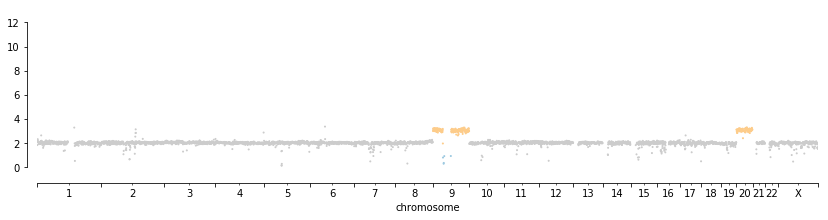

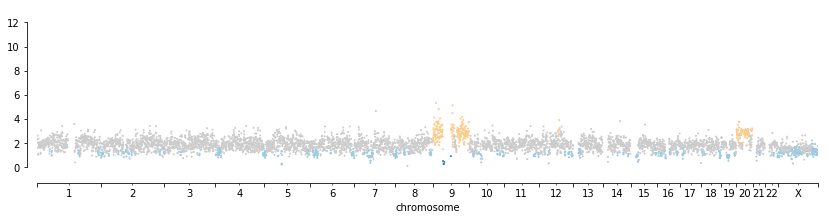

In [107]:

import matplotlib

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, plot_clone_cn.query('cluster_id == "{}"'.format('58')), 'copy', 'integer_copy_number')

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)
scgenome.cnplot.plot_cell_cn_profile(
    ax, cn_data.query('cell_id == "{}"'.format(cell_id)), 'copy', 'integer_copy_number')



In [35]:

metrics_data.groupby('cluster_id')['is_s_phase'].mean()


KeyError: 'cluster_id'

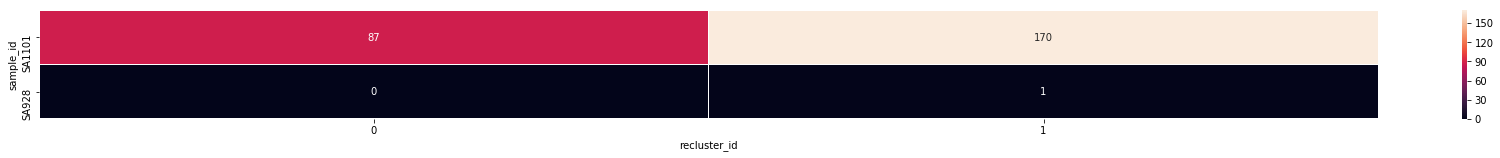

In [130]:

plot_data = metrics_data.merge(recluster_df).groupby(['recluster_id', 'sample_id']).size().unstack(fill_value=0).T
plt.figure(figsize=(30, 2))
seaborn.heatmap(plot_data, annot=True, fmt="d", linewidths=.5)


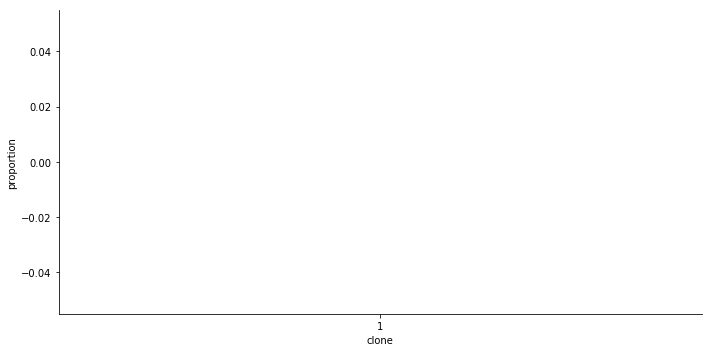

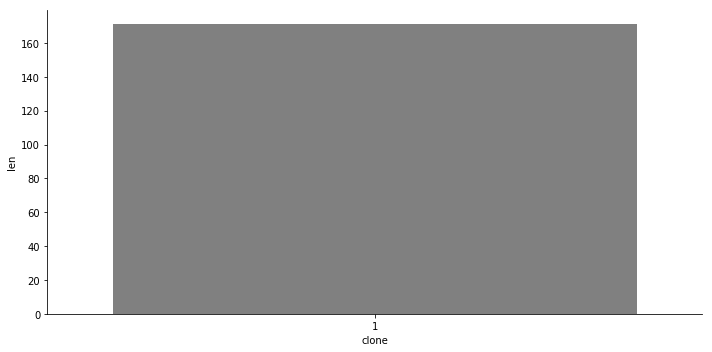

In [131]:

plot_data = metrics_data.merge(recluster_df).groupby('recluster_id').agg({'is_s_phase': (np.sum, len, np.mean)}).reset_index()
plot_data.columns = ['clone', 'sum', 'len', 'proportion']
plot_data = plot_data[plot_data['len'] > 100]
# plot_data = plot_data.stack()
plot_data
# .stack().reset_index()
# plot_data.columns = ['clone', 'feature', 'is_s_phase']

seaborn.factorplot(x='clone', y='proportion', kind='bar', data=plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='len', kind='bar', data=plot_data, color='0.5', aspect=2)



In [39]:

metrics_data.iloc[0]


MBRSI_dispersion_non_integerness                  0.302992
MBRSM_dispersion                                  0.277499
MSRSI_non_integerness                             0.141317
autocorrelation_hmmcopy                           0.472692
breakpoints                                             95
cell_call                                               C1
cell_id                             SA1101-A96181C-R64-C28
column                                                  28
cv_hmmcopy                                        0.276638
empty_bins_hmmcopy                                       0
experimental_condition                                p50a
img_col                                                 45
index                                                    0
index_i5                                             i5-64
index_i7                                             i7-28
index_sequence                                         NaN
log_likelihood                                    -4461.

,count,Diameter,is_s_phase
recluster_id,,,
2,529,149.657845,0.306238
11,501,187.710579,0.219561
25,398,189.015075,0.286432


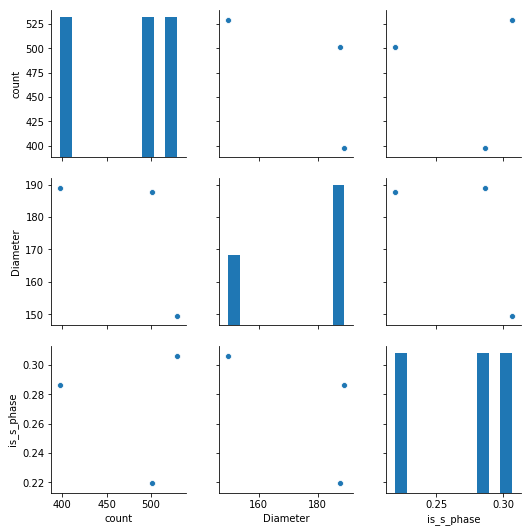

In [45]:

plot_data = metrics_data.merge(image_feature_data, on=['brief_cell_id', 'library_id'])
plot_data = plot_data.query('spotter == "rachael"')

plot_data['count'] = 1
plot_data = plot_data.merge(recluster_df).groupby('recluster_id').agg({'is_s_phase': np.mean, 'count': np.sum, 'Diameter': np.mean})
plot_data = plot_data[plot_data['count'] > 100]
# .stack()
# plot_data = plot_data.reset_index()
# plot_data.columns = ['clone', 'feature', 'value']

seaborn.pairplot(plot_data)

plot_data

# plot_data.iloc[0]

# seaborn.factorplot(
# #     hue='is_s_phase',
#     y='Diameter',
#     x='cluster_id',
#     kind='bar',
#     data=plot_data,
#     aspect=2,
#     dodge=True,
# )
